In [1]:
%load_ext autoreload
%autoreload 2

# Introduction and Objective
## Debugging the data used for training with MultiTask Learning

This notebook should be executed after `train_test_split.ipynb`

In [2]:
import h5py
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from cvmt.utils import (
    nested_dict_to_easydict
)

from cvmt.ml.utils import (
    HDF5MultitaskDataset,
    ResizeTransform,
    Coord2HeatmapTransform,
    CustomToTensor,
    MultitaskCollator,
    plot_image_landmarks,
    plot_many_heatmaps,
    RandomHorFlip,
    CustomScaleto01,
    GaussianBlurTransform,
    RandomRotationTransform,
    RightResizedCrop,
)

from cvmt.data.utils import (
    harmonize_hdf5,
    read_harmonized_hdf5,
    load_and_clean_image_and_annotations
)

from cvmt.data.prep import PrepDataset

/home/samehr/Desktop/cephal/cvmt/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-10 15:49:31,625	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', None)

In [4]:
os.chdir("../../")

# load parameters

In [5]:
with open("configs/params.yaml") as f:
    PARAMS = yaml.safe_load(f)
    PARAMS = nested_dict_to_easydict(PARAMS)

In [6]:
print(PARAMS)

{'RAW_DATA_DIRECTORY': 'data/raw', 'INTERMEDIATE_DATA_DIRECTORY': 'data/intermediate', 'PRIMARY_DATA_DIRECTORY': 'data/primary', 'ARTIFACTS_DATA_DIRECTORY': 'artifacts', 'RAW': {'DATASET_1': {'RAW_ZIP_FILE_NAME': 'radiography-20221212T190109Z-001.zip', 'RAW_ZIP_NEW_ANNOT_FILE_NAME': 'label_edited-20230122T143005Z-001.zip', 'INTERMEDIATE_DIR_NAME': 'dataset_1', 'UNWANTED_JSON_FIELDS': ['imageData']}, 'DATASET_3': {'RAW_RAR_FILE_NAME': 'RawImage.rar', 'RAW_DIR_NAME_TEMP': 'dataset_3_bmp', 'RAW_DIR_NAME': 'dataset_3_raw_data'}}, 'INTERM': {'UNWANTED_JSON_FIELDS': ['imageData', 'imagePath'], 'N_PROCESSES': 3, 'DATASET_1': {'DIR_NAME': 'dataset_1_interm_data-20230513T084705Z-001', 'IMG_DIR_NAME': ['image'], 'V_LANDMARKS_DIR_NAME': ['label'], 'F_LANDMARKS_DIR_NAME': None}, 'DATASET_2': {'DIR_NAME': 'dataset_2_interm_data-20230304T160421Z-001', 'IMG_DIR_NAME': ['image'], 'V_LANDMARKS_DIR_NAME': ['label'], 'F_LANDMARKS_DIR_NAME': None}, 'DATASET_3': {'DIR_NAME': 'dataset_3_interm_data-20230304

In [7]:
metadata_table = pd.read_hdf(
    os.path.join(PARAMS.PRIMARY_DATA_DIRECTORY, PARAMS.TRAIN.METADATA_TABLE_NAME),
    key='df',
)

In [8]:
metadata_table.head()

,valid_v_annots,valid_f_annots,edges_present,harmonized_id,source_image_filename,dataset,dev_set,v_annots_2_rows,v_annots_2_cols,v_annots_3_rows,v_annots_3_cols,v_annots_4_rows,v_annots_4_cols,f_annots_rows,f_annots_cols,split
0,True,False,True,e7a3e0bb80db6d289234,45.jpg,dataset_1,NaN,3.0,2.0,5.0,2.0,5.0,2.0,NaN,NaN,train
1,True,False,True,4cee5b9bf553bb7bef43,92.jpg,dataset_1,NaN,3.0,2.0,5.0,2.0,5.0,2.0,NaN,NaN,val
2,True,False,True,c8a75bb00e9339608268,43.jpg,dataset_1,NaN,3.0,2.0,5.0,2.0,5.0,2.0,NaN,NaN,train
3,True,False,True,0d1d0d042edf35bd316c,7.jpg,dataset_1,NaN,3.0,2.0,5.0,2.0,5.0,2.0,NaN,NaN,train
4,True,False,True,5a3b5c5837f813eca6ad,121.jpg,dataset_1,NaN,3.0,2.0,5.0,2.0,5.0,2.0,NaN,NaN,train


In [9]:
metadata_table.describe()

,v_annots_2_rows,v_annots_2_cols,v_annots_3_rows,v_annots_3_cols,v_annots_4_rows,v_annots_4_cols
count,789.0,789.0,789.0,789.0,789.0,789.0
mean,3.0,2.0,5.0,2.0,5.0,2.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,3.0,2.0,5.0,2.0,5.0,2.0
25%,3.0,2.0,5.0,2.0,5.0,2.0
50%,3.0,2.0,5.0,2.0,5.0,2.0
75%,3.0,2.0,5.0,2.0,5.0,2.0
max,3.0,2.0,5.0,2.0,5.0,2.0


In [10]:
v_annots_present = metadata_table.loc[metadata_table['valid_v_annots'] == True, [
    'valid_v_annots', 'harmonized_id', 'dataset', 'v_annots_2_rows', 'v_annots_2_cols', 
    'v_annots_3_rows', 'v_annots_3_cols', 'v_annots_4_rows', 'v_annots_4_cols', 'split']
]

In [11]:
v_annots_present.head()

,valid_v_annots,harmonized_id,dataset,v_annots_2_rows,v_annots_2_cols,v_annots_3_rows,v_annots_3_cols,v_annots_4_rows,v_annots_4_cols,split
0,True,e7a3e0bb80db6d289234,dataset_1,3.0,2.0,5.0,2.0,5.0,2.0,train
1,True,4cee5b9bf553bb7bef43,dataset_1,3.0,2.0,5.0,2.0,5.0,2.0,val
2,True,c8a75bb00e9339608268,dataset_1,3.0,2.0,5.0,2.0,5.0,2.0,train
3,True,0d1d0d042edf35bd316c,dataset_1,3.0,2.0,5.0,2.0,5.0,2.0,train
4,True,5a3b5c5837f813eca6ad,dataset_1,3.0,2.0,5.0,2.0,5.0,2.0,train


In [12]:
v_annots_present.shape

(789, 10)

In [13]:
display(metadata_table.groupby(['split', 'dataset']).apply(lambda x: len(x)))

split      dataset  
test       dataset_1     28
           dataset_2     12
           dataset_3     76
           dataset_4     43
train      dataset_1     84
           dataset_2     36
           dataset_3    224
           dataset_4    129
undefined  dataset_1      2
           dataset_2     19
           dataset_3     26
           dataset_4      8
val        dataset_1     28
           dataset_2     12
           dataset_3     74
           dataset_4     43
dtype: int64

In [14]:
display(metadata_table.groupby('split').apply(lambda x: x.loc[:,['valid_v_annots', 'valid_f_annots']].describe()))

valid_v_annots valid_f_annots
split                                         
test      count             159            159
          unique              1              2
          top              True          False
          freq              159             83
train     count             473            473
          unique              1              2
          top              True          False
          freq              473            249
undefined count              55             55
          unique              1              2
          top             False          False
          freq               55             29
val       count             157            157
          unique              1              2
          top              True          False
          freq              157             83

# Data for task 2 of the training

In [15]:
# define the task id
task_id = 2

# create the right list of paths
train_file_list = metadata_table.loc[
    (metadata_table['split']=='train') & (
    metadata_table['edges_present']==True) & (
    metadata_table['valid_v_annots']==True
    ), ['harmonized_id']
].to_numpy().ravel().tolist()

train_file_list = [
    os.path.join(PARAMS.PRIMARY_DATA_DIRECTORY, file_path+'.hdf5') for file_path in train_file_list
]

# instantiate the transforms
my_transforms = transforms.Compose([
    ResizeTransform(tuple(PARAMS.TRAIN.TARGET_IMAGE_SIZE)),
    CustomToTensor(),
])

# instantiate the dataset and dataloader objects
train_dataset = HDF5MultitaskDataset(
    file_paths=train_file_list,
    task_id=task_id,
    transforms=my_transforms,
)
collator_task = MultitaskCollator(
    task_id=task_id,
)
dataloader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=collator_task
)

In [16]:
for batch in dataloader:
    print(type(batch))
    # Train the model on this batch
    break

<class 'dict'>


In [17]:
batch = [{k:v[i] for k, v in batch.items()} for i in range(len(batch['image']))]

<class 'torch.Tensor'>
edges:  torch.Size([1, 256, 256])



/home/samehr/Desktop/cephal/cvmt/cvmt/ml/utils.py:614: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=45)


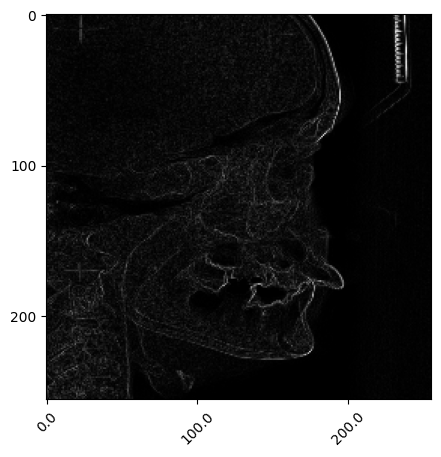

In [18]:
samples = []
v_shapes = []
for i, sample in enumerate(batch):
    print(type(sample['edges']))
    print("edges: ", sample['edges'].shape)
    if 'v_landmarks'in sample and sample['v_landmarks'] is not None:
        print("v_landmarks: ", sample['v_landmarks'].shape)
    if 'f_landmarks' in sample and sample['f_landmarks'] is not None:
        print("f_landmarks: ", sample['f_landmarks'].shape)
    print()

    # plot
    v_landmarks = sample['v_landmarks'] if 'v_landmarks' in sample else None
    f_landmarks = sample['f_landmarks'] if 'f_landmarks' in sample else None
    edges = sample['edges'][0,...]

    plot_image_landmarks(
        edges,
        v_landmarks,
        f_landmarks,
    )
    print()
    break

# Data for task 3 of the training

In [19]:
# define the task id
task_id = 3

# create the right list of paths
train_file_list = metadata_table.loc[
    (metadata_table['split']=='train') & (metadata_table['valid_v_annots']==True), ['harmonized_id']
].to_numpy().ravel().tolist()

train_file_list = [
    os.path.join(PARAMS.PRIMARY_DATA_DIRECTORY, file_path+'.hdf5') for file_path in train_file_list
]

# instantiate the transforms
my_transforms = transforms.Compose([
    ResizeTransform(tuple(PARAMS.TRAIN.TARGET_IMAGE_SIZE)),
    CustomToTensor(),
])

# instantiate the dataset and dataloader objects
train_dataset = HDF5MultitaskDataset(
    file_paths=train_file_list,
    task_id=task_id,
    transforms=my_transforms,
)
collator_task = MultitaskCollator(
    task_id=task_id,
)
dataloader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=collator_task
)

### sanity check the dataset and dataloader

In [20]:
for batch in dataloader:
    print(type(batch))
    # Train the model on this batch
    break

<class 'dict'>


In [21]:
batch = [{k:v[i] for k, v in batch.items()} for i in range(len(batch['image']))]

<class 'torch.Tensor'>
image:  torch.Size([1, 256, 256])
v_landmarks:  torch.Size([13, 2])



/home/samehr/Desktop/cephal/cvmt/cvmt/ml/utils.py:614: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=45)


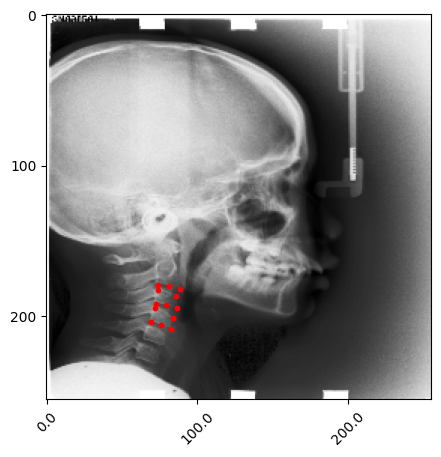

In [22]:
for i, sample in enumerate(batch):
    print(type(sample['image']))
    print("image: ", sample['image'].shape)
    if 'v_landmarks'in sample and sample['v_landmarks'] is not None:
        print("v_landmarks: ", sample['v_landmarks'].shape)
    if 'f_landmarks' in sample and sample['f_landmarks'] is not None:
        print("f_landmarks: ", sample['f_landmarks'].shape)
    print()

    # plot
    v_landmarks = sample['v_landmarks'] if 'v_landmarks' in sample else None
    f_landmarks = sample['f_landmarks'] if 'f_landmarks' in sample else None
    image = sample['image'][0,...]

    plot_image_landmarks(
        image,
        v_landmarks,
        f_landmarks,
    )
    print()
    break

# Data for task 4 of the training

In [23]:
# define the task id
task_id = 4

# create the right list of paths
train_file_list = metadata_table.loc[
    (metadata_table['split']=='train') & (metadata_table['valid_f_annots']==True), ['harmonized_id']
].to_numpy().ravel().tolist()

train_file_list = [
    os.path.join(PARAMS.PRIMARY_DATA_DIRECTORY, file_path+'.hdf5') for file_path in train_file_list
]

# instantiate the transforms
my_transforms = transforms.Compose([
    ResizeTransform(tuple(PARAMS.TRAIN.TARGET_IMAGE_SIZE)),
    CustomToTensor(),
])

# instantiate the dataset and dataloader objects
train_dataset = HDF5MultitaskDataset(
    file_paths=train_file_list,
    task_id=task_id,
    transforms=my_transforms,
)
collator_task = MultitaskCollator(
    task_id=task_id,
)
dataloader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    collate_fn=collator_task
)

### sanity check the dataset and dataloader

In [24]:
for batch in dataloader:
    print(type(batch))
    # Train the model on this batch
    break

<class 'dict'>


In [25]:
batch = [{k:v[i] for k, v in batch.items()} for i in range(len(batch['image']))]

<class 'torch.Tensor'>
image:  torch.Size([1, 256, 256])
f_landmarks:  torch.Size([19, 2])



/home/samehr/Desktop/cephal/cvmt/cvmt/ml/utils.py:614: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=45)


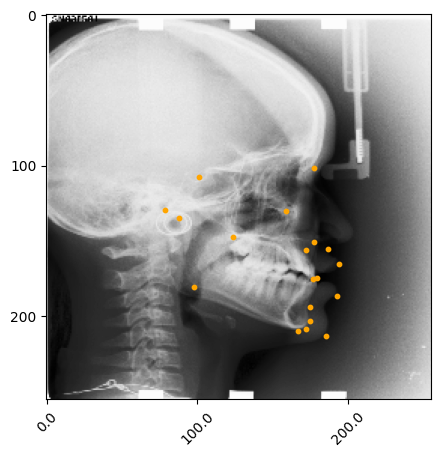

In [26]:
samples = []
v_shapes = []
for i, sample in enumerate(batch):
    print(type(sample['image']))
    print("image: ", sample['image'].shape)
    if 'v_landmarks'in sample and sample['v_landmarks'] is not None:
        print("v_landmarks: ", sample['v_landmarks'].shape)
    if 'f_landmarks' in sample and sample['f_landmarks'] is not None:
        print("f_landmarks: ", sample['f_landmarks'].shape)
    print()

    # plot
    v_landmarks = sample['v_landmarks'] if 'v_landmarks' in sample else None
    f_landmarks = sample['f_landmarks'] if 'f_landmarks' in sample else None
    image = sample['image'][0,...]

    plot_image_landmarks(
        image,
        v_landmarks,
        f_landmarks,
    )
    print()
    break

# Sanity check transformed coordinate landmarks to heatmaps

## Task 3

In [27]:
# define the task id
task_id = 3

# create the right list of paths
train_file_list = metadata_table.loc[
    (metadata_table['split']=='train') & (metadata_table['dataset']=='dataset_3') & (metadata_table['valid_v_annots']==True), ['harmonized_id']
].to_numpy().ravel().tolist()

train_file_list = [
    os.path.join(PARAMS.PRIMARY_DATA_DIRECTORY, file_path+'.hdf5') for file_path in train_file_list
]

# instantiate the transforms
my_transforms = transforms.Compose([
    ResizeTransform(tuple(PARAMS.TRAIN.TARGET_IMAGE_SIZE)),
    Coord2HeatmapTransform(
        tuple(PARAMS.TRAIN.TARGET_IMAGE_SIZE),
        PARAMS.TRAIN.GAUSSIAN_COORD2HEATMAP_STD
    ),
    CustomScaleto01(),
    CustomToTensor(),
    # RandomRotationTransform(degrees=(5,10)),
    #RandomHorFlip(0.5),
    #GaussianBlurTransform(kernel_size=3, sigma=0.2, p=1),
    RightResizedCrop(width_scale=(0.9,1.0), p=1)
])

# instantiate the dataset and dataloader objects
train_dataset = HDF5MultitaskDataset(
    file_paths=train_file_list,
    task_id=task_id,
    transforms=my_transforms,
)
collator_task = MultitaskCollator(
    task_id=task_id,
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collator_task
)

### sanity check the dataset and dataloader

#### dataset

#### dataloader

<class 'dict'>
<class 'torch.Tensor'>
image:  torch.Size([1, 256, 256])
v_landmarks:  torch.Size([13, 256, 256])



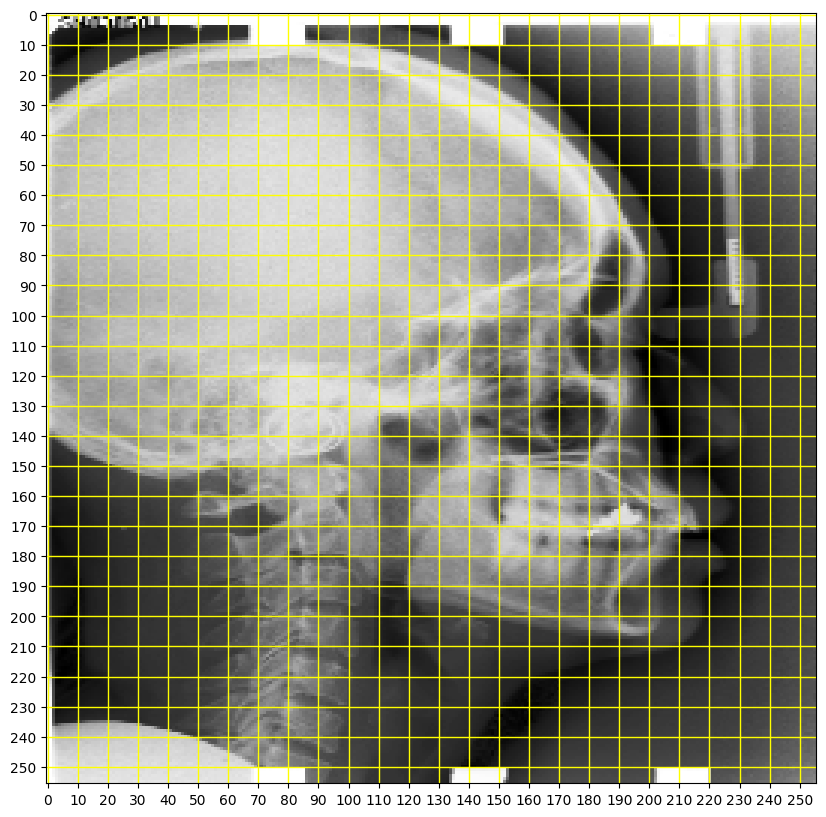

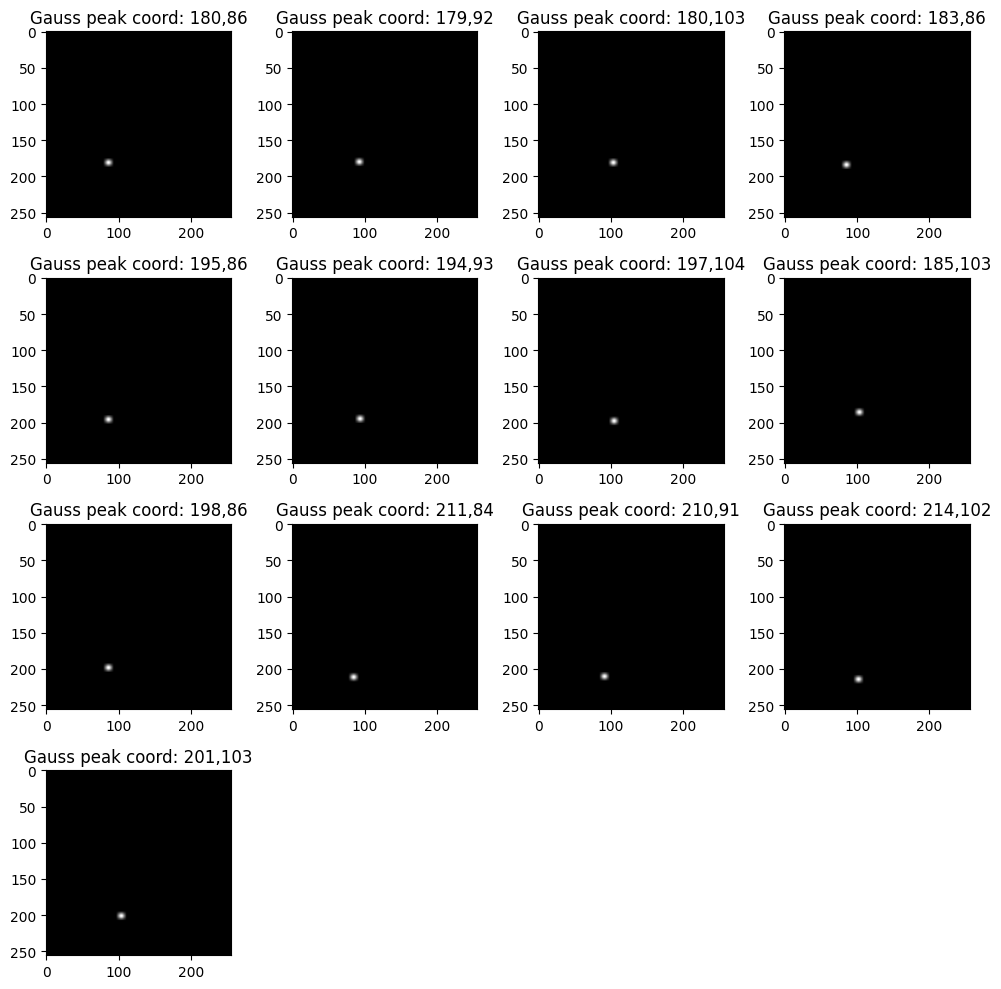


<class 'dict'>
<class 'torch.Tensor'>
image:  torch.Size([1, 256, 256])
v_landmarks:  torch.Size([13, 256, 256])



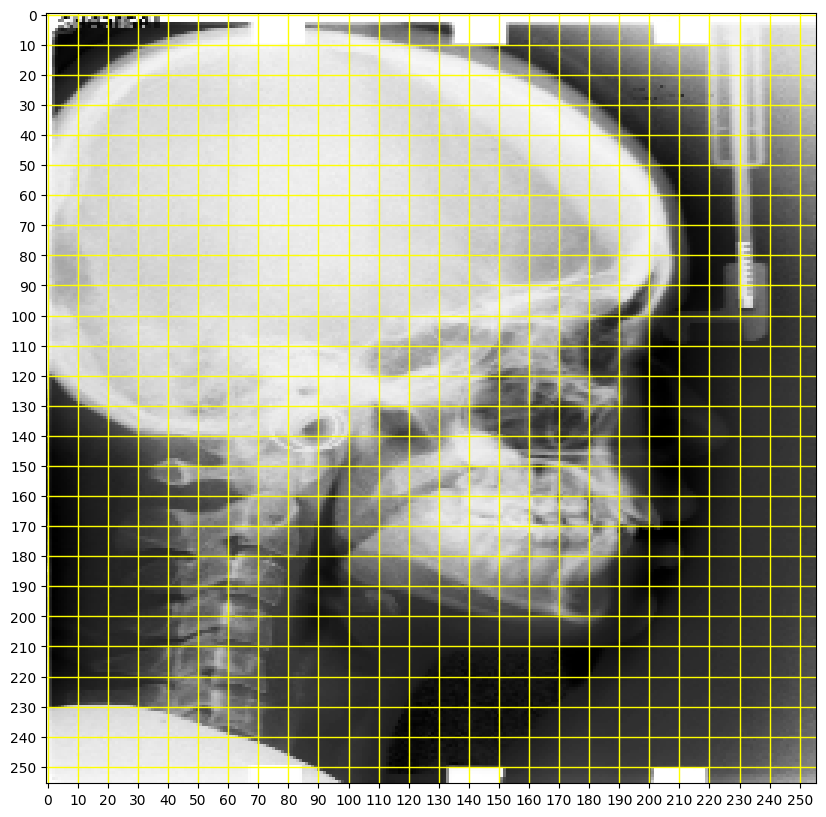

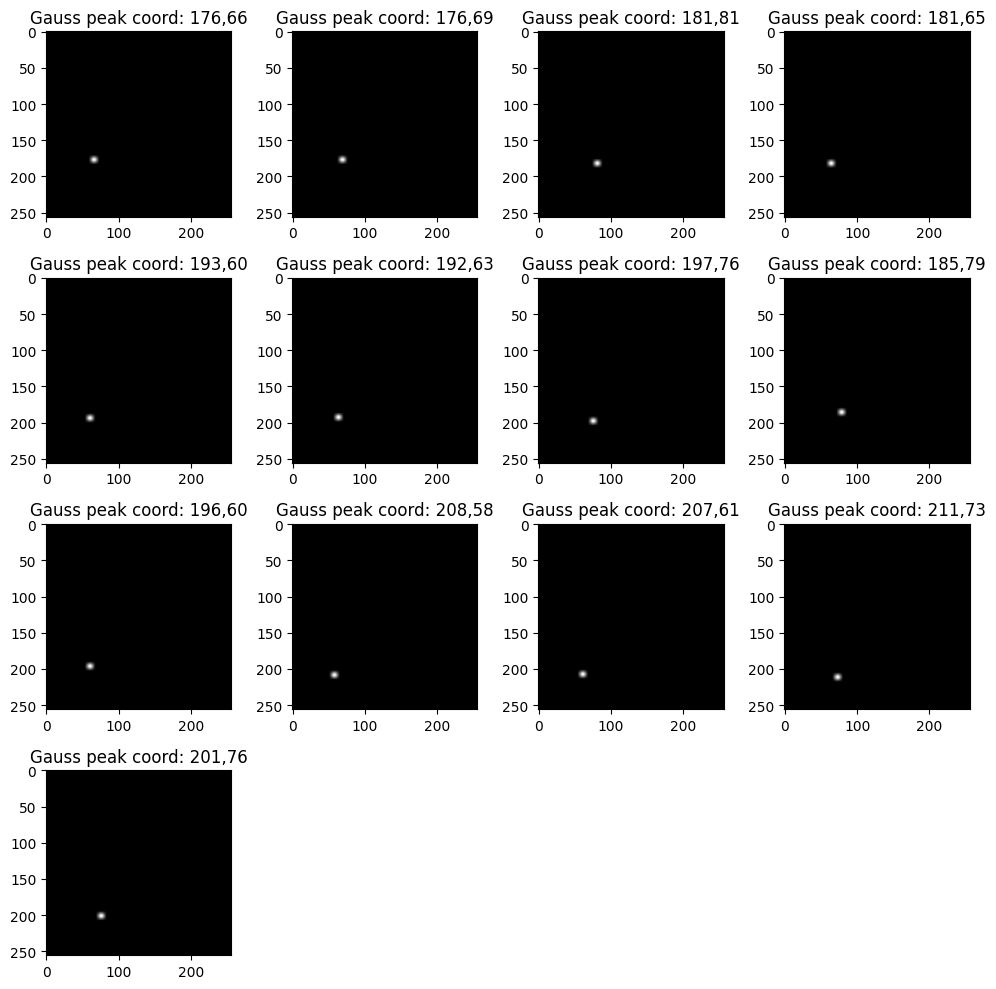


<class 'dict'>
<class 'torch.Tensor'>
image:  torch.Size([1, 256, 256])
v_landmarks:  torch.Size([13, 256, 256])



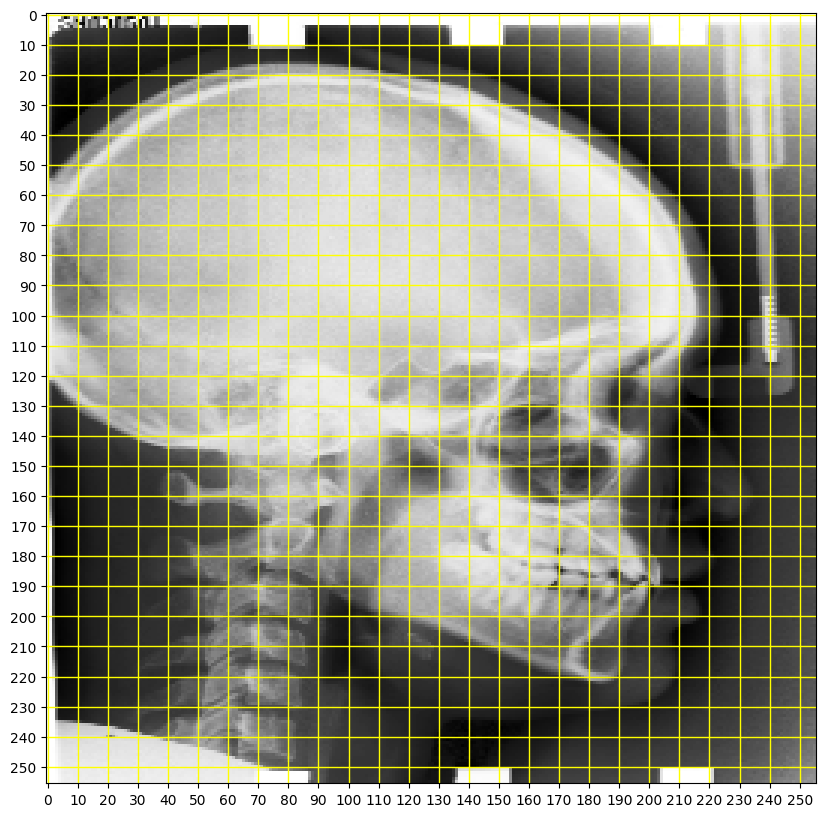

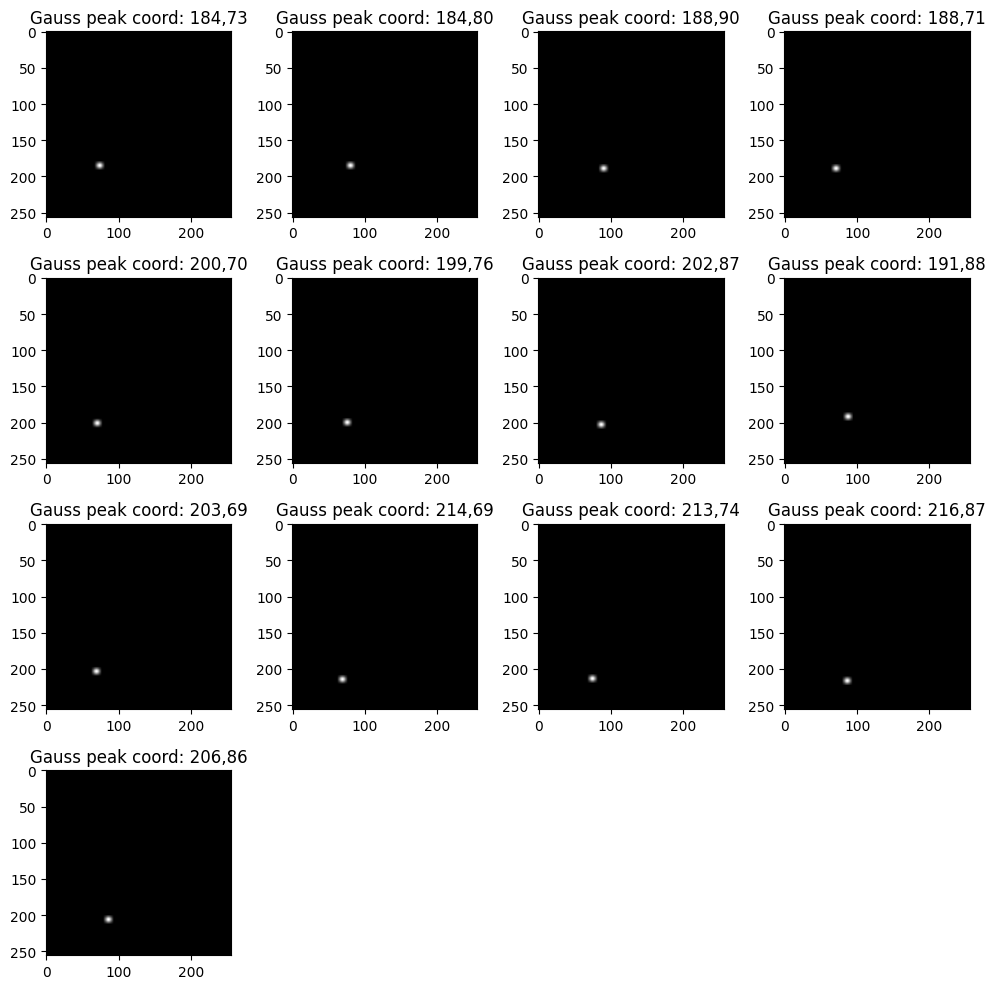


<class 'dict'>
<class 'torch.Tensor'>
image:  torch.Size([1, 256, 256])
v_landmarks:  torch.Size([13, 256, 256])



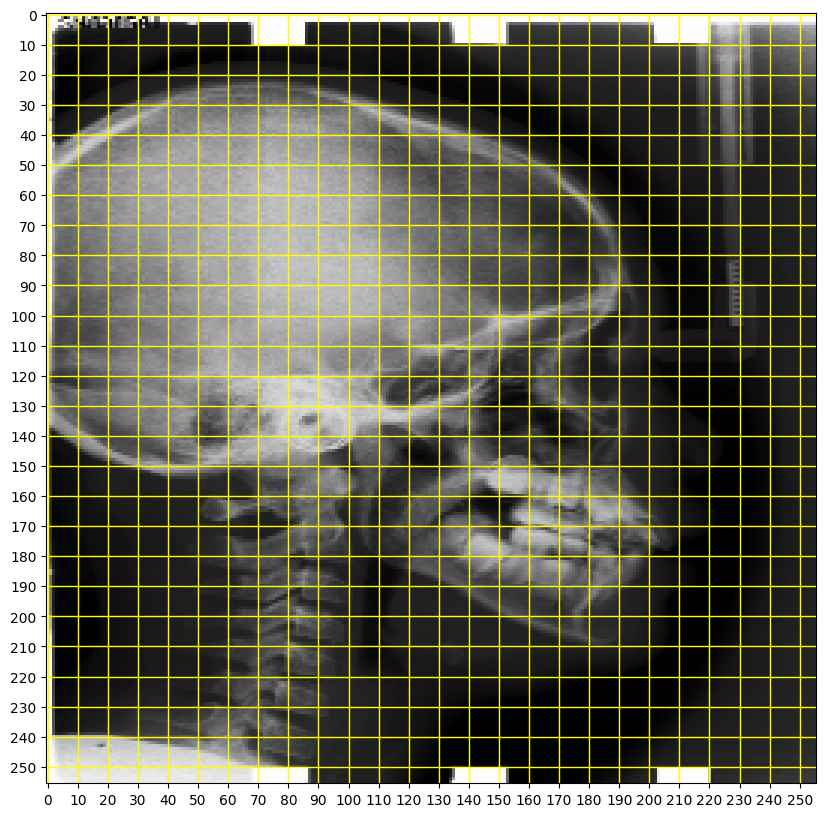

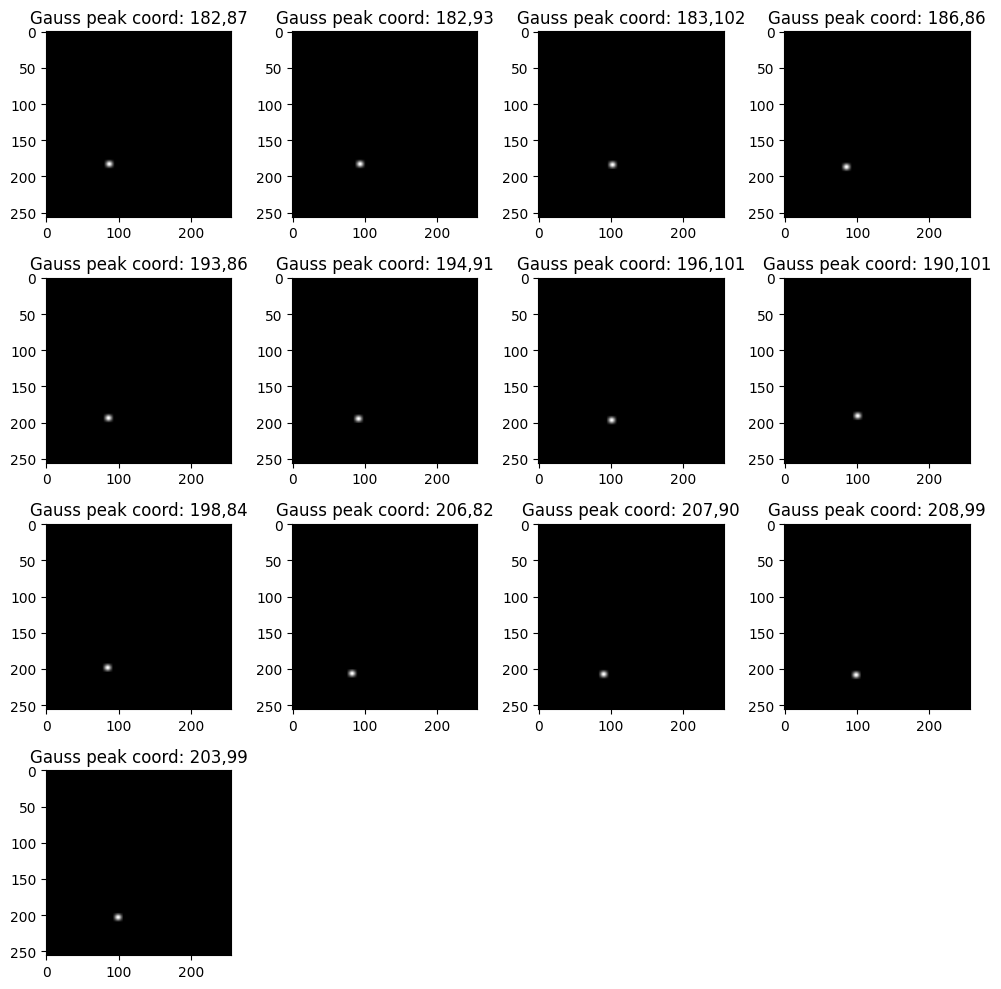


<class 'dict'>


In [28]:
for i, batch in enumerate(train_dataloader):
    print(type(batch))
    # Train the model on this batch
    #break
    
    if i == 4:
        break
    batch = [{k:v[i] for k, v in batch.items()} for i in range(len(batch['image']))]

    samples = []
    v_shapes = []
    for i, sample in enumerate(batch):
        print(type(sample['image']))
        print("image: ", sample['image'].shape)
        if 'v_landmarks'in sample and sample['v_landmarks'] is not None:
            print("v_landmarks: ", sample['v_landmarks'].shape)
        if 'f_landmarks' in sample and sample['f_landmarks'] is not None:
            print("f_landmarks: ", sample['f_landmarks'].shape)
        print()

        # plot
        v_landmarks = sample['v_landmarks'] if 'v_landmarks' in sample else None
        f_landmarks = sample['f_landmarks'] if 'f_landmarks' in sample else None
        image = sample['image'][0,...]
        fig, ax = plt.subplots(figsize=(10,10),)
        ax.imshow(sample['image'].numpy()[0,:,:], cmap='gray')
        x_ticks = np.arange(0, image.size(-1), 10)
        y_ticks = np.arange(0, image.size(-2), 10)
        plt.xticks(x_ticks)
        plt.yticks(y_ticks)
        plt.grid(True, color='yellow', linestyle='-', linewidth=1,)
        plt.show()
        
        plot_many_heatmaps(v_landmarks)
        print()


In [29]:
sample['image'].shape

torch.Size([1, 256, 256])

In [30]:
sample['v_landmarks'].shape

torch.Size([13, 256, 256])